In [16]:
import warnings
# Comment this
warnings.filterwarnings('ignore')  

import pandas as pd
from utils import clean_text, plot_confusion_matrix
import numpy as np
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

RANDOM_STATE = 42

### Loading Data

In [2]:
df = pd.read_csv("train.csv")
df.head()

,id,App Version Code,App Version Name,Review Text,Review Title,Star Rating
0,b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9,NaN,NaN,Very bad wallet balance not use.,NaN,1
1,c7844e8f-56c1-487b-ae3e-df2fdf4c1767,43.0,2.30,Froud app i recharge 199 but not done also sen...,NaN,1
2,93ff57f7-9e02-4fa9-b779-3db82b8af0a4,52.0,2.12,Waste to write comments also,Waste no use,2
3,df2dcdef-c09a-4f35-afab-e1231d3fec9a,62.0,2.21,Nice apo,NaN,5
4,11f8f968-4cec-4424-8427-9709ab05b5be,69.0,2.28,Good nice app,NaN,5


### Data Insights and Processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693 entries, 0 to 5692
Data columns (total 6 columns):
id                  5693 non-null object
App Version Code    4554 non-null float64
App Version Name    4554 non-null float64
Review Text         5692 non-null object
Review Title        602 non-null object
Star Rating         5693 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 266.9+ KB


* Only one "Review Text" is NULL
* Many "Review Title" are NULL

In [4]:
# Print the row with "Review Text" to check wether we can use the title.
review_nan_index = df.index[df["Review Text"].isna()][0]
print(df.iloc[review_nan_index])

id                  e5c14e2d-ab19-48c6-a19f-ed19f21c0851
App Version Code                                     NaN
App Version Name                                     NaN
Review Text                                          NaN
Review Title                           Fine but not good
Star Rating                                            3
Name: 1556, dtype: object


- Looks usable

In [5]:
# Replace Nan with empty string
df.fillna("", inplace=True)

# df["sentence"] = df.apply(lambda row: ) 
df['text'] = df['Review Title'] + " " + df['Review Text']
df.drop(["Review Text", "Review Title", "id", "App Version Code", "App Version Name"], 
        inplace=True, axis=1)
df.rename(columns={"Star Rating":"sentiment"}, inplace=True)
df.head()

,sentiment,text
0,1,Very bad wallet balance not use.
1,1,Froud app i recharge 199 but not done also se...
2,2,Waste no use Waste to write comments also
3,5,Nice apo
4,5,Good nice app


Need to take care of wrong spelling, Hindi Words
 - Use char level models: FastTxt
 - SpellCheckers

###  Clean Text

In [6]:
df.text = df.text.apply(clean_text)
df["word_count"] = df.text.apply(lambda para : len(para.split()))

### Visualizing Data

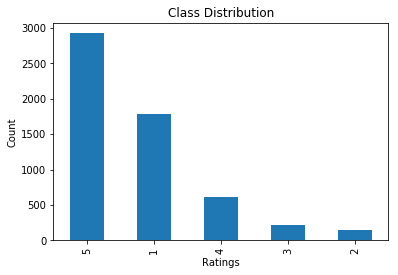

In [7]:
# checking class imbalance
ax = df.sentiment.value_counts().plot(kind='bar',
                                title='Class Distribution')
ax.set_xlabel("Ratings")
ax.set_ylabel("Count")
plt.show()

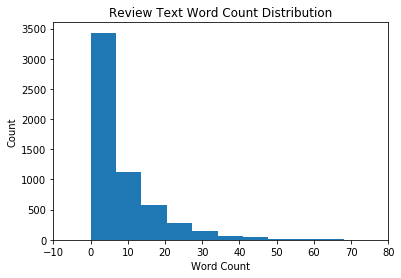

In [8]:
# Review Text Word Count Distribution
# sns.distplot(df.word_count)
ax = df.word_count.plot(kind='hist', 
                        bins = 50,
                        title='Review Text Word Count Distribution')
ax.set_xlabel("Word Count")
ax.set_ylabel("Count")
ax.set_xlim(-10, 80)
plt.show()

In [9]:
# Need to use fasttxt, Checkign if small lens are outliers.

# Outliers, but seems like it can be used, otherwise less data
# Try keeping and removing both
single_word_table = pd.pivot_table(df[df.word_count == 1], columns=["text"], index=["sentiment"],
                                  aggfunc = 'count')
print(single_word_table)

          word_count                                                         \
text              aa abhishek akakakw amaz aswm averag awasom awesom awosom   
sentiment                                                                     
1                NaN      NaN     NaN  NaN  NaN    NaN    NaN    NaN    NaN   
2                NaN      1.0     NaN  NaN  NaN    NaN    NaN    NaN    NaN   
3                NaN      NaN     NaN  NaN  NaN    1.0    NaN    NaN    NaN   
4                NaN      NaN     NaN  1.0  NaN    NaN    NaN    5.0    NaN   
5                1.0      NaN     1.0  8.0  1.0    NaN    1.0   62.0    1.0   

                ...                                                       \
text      awsm  ... winking_fac wonder worest wors worst  wow wrost   ye   
sentiment       ...                                                        
1          NaN  ...         NaN    NaN    1.0  1.0   7.0  NaN   1.0  NaN   
2          NaN  ...         NaN    NaN    NaN  NaN   NaN  NaN  

In [10]:
# Rechecking df before training
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693 entries, 0 to 5692
Data columns (total 3 columns):
sentiment     5693 non-null int64
text          5693 non-null object
word_count    5693 non-null int64
dtypes: int64(2), object(1)
memory usage: 133.5+ KB


### Learning

In [11]:
# Model
# Return Model List, Model Socre, Best Model
# Verbose: True: print cross validation results
def train_model(X, y, verbose = True):
    svm_pgrid = {"C": [1, 3],
                "kernel": ['rbf', 'poly'],
                "class_weight":[None, "balanced"]}

    rf_pgrid = {"n_estimators": [10, 50, 100, 250],
                "max_depth": [2, 5, 10, 15],
                "class_weight":[None, "balanced"]}

    nn_pgrid = {"n_neighbors": [5, 10, 15]}

    cv = 5 # 5-fold
    scoring_metric = 'f1_weighted'

    # Classifiers with GridSearchCv with startifiedKfold and 
    # wieghtedf1 score and balanced
    classifiers = [
#         ["SVC", GridSearchCV(estimator=SVC(), 
#                              param_grid=svm_pgrid, cv=cv, 
#                              scoring=scoring_metric, iid=False)],
        ["Random Forest", GridSearchCV(estimator=RandomForestClassifier(),
                                      param_grid=rf_pgrid, cv=cv,
                                      scoring=scoring_metric, iid=False)],
        ["Nearest Neighbour", GridSearchCV(estimator=KNeighborsClassifier(),
                                          param_grid=nn_pgrid, cv=cv, 
                                        scoring=scoring_metric, iid=False)]
    ]
    
    CV_classifiers = []
    CV_best_scores = []
    
    for name, clf in classifiers:
        clf.fit(X, y)
        CV_classifiers.append(clf.best_estimator_)
        CV_best_scores.append(clf.best_score_)
        if verbose:
            print("--------------------------------------------------------------")
            print("Cross Validation Results for:", name)
            print(clf.cv_results_)
            print("--------------------------------------------------------------\n\n")
        print("Classifier:", name, "=> Wieghted F1:", clf.best_score_)
        print("Best Params:")
        print(clf.best_params_)
        
    best_model = CV_classifiers[CV_best_scores.index(max(CV_best_scores))]
    return CV_classifiers, CV_best_scores, best_model, max(CV_best_scores)


In [14]:
# Print Confusion Matrix
# Warning: will again train (for separating validation data) the model. 
def retrain_best_param_model_confusion(model, X, y, title="Confusion Matrix"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    #print(confusion_matrix(y_test, y_pred))
    ax = plot_confusion_matrix(y_test, y_pred, ["1","2","3","4","5"], title=title)
    plt.show()

Classifier: Random Forest => Wieghted F1: 0.6713076295402983
Best Params:
{'class_weight': 'balanced', 'n_estimators': 100, 'max_depth': 15}
Classifier: Nearest Neighbour => Wieghted F1: 0.6634074847622011
Best Params:
{'n_neighbors': 15}
Best F1 score: 0.6713076295402983
Confusion matrix, without normalization
[[343   9  11   6  52]
 [ 15   0   1   5  11]
 [ 28   2   7  11  17]
 [ 21   0   1  49  85]
 [ 32   1   3 174 540]]


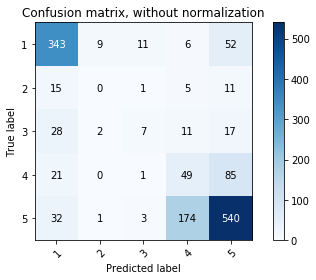

In [13]:
# TF-IDF feature
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=1.0, min_df=1)
Xnorm = tfidf_vectorizer.fit_transform(df.text)
ynorm = df.sentiment.to_list()
model, score, best_model_norm, best_score = train_model(Xnorm, ynorm, verbose=False)
print("Best F1 score:", best_score)
retrain_best_param_model_confusion(best_model_norm, Xnorm, ynorm, title="Confusion Matrix With Normal Data")

Counter({1: 2923, 2: 2923, 3: 2923, 4: 2923, 5: 2923})
Classifier: Random Forest => Wieghted F1: 0.7648080179759413
Best Params:
{'class_weight': None, 'n_estimators': 200, 'max_depth': 15}
Classifier: Nearest Neighbour => Wieghted F1: 0.7556090243155149
Best Params:
{'n_neighbors': 5}
Best F1 score: 0.7648080179759413
Confusion matrix, without normalization
[[601  17  17  10  89]
 [ 27 666   0  39  25]
 [ 24   1 520 105  96]
 [ 34   4   2 415 261]
 [ 22   3   9 155 512]]


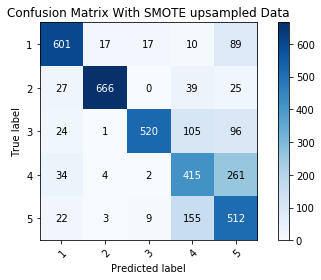

In [18]:
# SMOTE oversampling for imabalance data (Can lead to overfitting for minority sometimes)
sm = SMOTE(random_state = RANDOM_STATE)
Xsmote, ysmote = sm.fit_sample(Xnorm, ynorm)
print("Class Counts:", Counter(ysmote))
model, score, best_model_smote, best_score = train_model(Xsmote, ysmote, verbose=False)
print("Best F1 score:", best_score)
retrain_best_param_model_confusion(best_model_smote, Xsmote, ysmote, title="Confusion Matrix With SMOTE upsampled Data")

Class Counts: Counter({2: 2810, 3: 2533, 4: 1739, 1: 1422, 5: 1351})
Classifier: Random Forest => Wieghted F1: 0.834095534426923
Best Params:
{'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 15}
Classifier: Nearest Neighbour => Wieghted F1: 0.8898096314287747
Best Params:
{'n_neighbors': 5}
Best F1 score: 0.8898096314287747
Confusion matrix, without normalization
[[335  22   7   6   0]
 [  0 703   1   0   0]
 [  0   1 639   1   0]
 [  1   6  22 400  11]
 [ 13  45  44  51 156]]


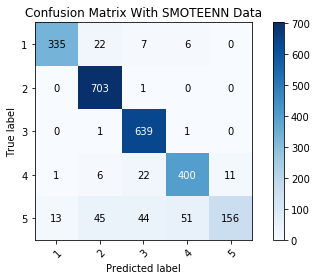

In [19]:
smenn = SMOTEENN(random_state = RANDOM_STATE)
Xsmotenn, ysmotenn = smenn.fit_sample(Xnorm, ynorm)
print("Class Counts:", Counter(ysmotenn))
model, score, best_model_smotenn, best_score = train_model(Xsmotenn, ysmotenn, verbose=False)
print("Best F1 score:", best_score)
retrain_best_param_model_confusion(best_model_smotenn, Xsmotenn, ysmotenn, title="Confusion Matrix With SMOTEENN Data")

In [20]:
# Filter outlier
pass

# Gonna try a deep learning model

### Process Test Data

In [23]:
dftest = pd.read_csv("test.csv")
dftest.info()

dftest.fillna("", inplace=True)
dftest['text'] = dftest['Review Title'] + " " + dftest['Review Text']
dftest.text = dftest.text.apply(clean_text)

dftest["Star Rating"] = best_model.predict(tfidf_vectorizer.transform(dftest.text))
dftest = dftest[["id", "Star Rating"]]
dftest.to_csv("submission.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 5 columns):
id                  1424 non-null object
App Version Code    1151 non-null float64
App Version Name    1151 non-null float64
Review Text         1423 non-null object
Review Title        180 non-null object
dtypes: float64(2), object(3)
memory usage: 55.7+ KB
